## Installing skmixed 

In [1]:
!git clone https://github.com/aksholokhov/skmixed
!cd skmixed 
!python setup.py develop
!pip install patsy

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple/
     |████████████████████████████████| 66 kB 972 kB/s eta 0:00:01
  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=ff14dce5f7f461016e0268d4adf40fa6fe7d7bdc4762c293f0164e1a2b2044f9
  Stored in directory: /Users/aksh/Library/Caches/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


If something goes wrong -- execute this to delete skmixed

In [3]:
!pip uninstall -y skmixed
!pip uninstall -y patsy

Found existing installation: patsy 0.5.1
Uninstalling patsy-0.5.1:
  Successfully uninstalled patsy-0.5.1


In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from patsy import dmatrix
%pylab inline

from sklearn.metrics import mean_squared_error, explained_variance_score

Populating the interactive namespace from numpy and matplotlib


We only need two elements from the library:

In [13]:
from skmixed.lme.problems import LinearLMEProblem
from skmixed.lme.models import LinearLMESparseModel

In [22]:
from skmixed.helpers import random_effects_to_matrix

## Creating a synthetic dataset

LinearLMEProblem.generate() generates a random Linear Mixed-Effects problem which satisfy the given criteria.

In [14]:
help(LinearLMEProblem.generate)

Help on function generate in module skmixed.lme.problems:

generate(groups_sizes: Union[List[Union[int, NoneType]], NoneType] = None, features_labels: Union[List[int], NoneType] = None, random_intercept: bool = False, features_covariance_matrix: Union[numpy.ndarray, NoneType] = None, obs_std: Union[int, float, Sized, NoneType] = 0.1, beta: Union[numpy.ndarray, NoneType] = None, gamma: Union[numpy.ndarray, NoneType] = None, true_random_effects: Union[numpy.ndarray, NoneType] = None, as_x_y=False, return_true_model_coefficients: bool = True, seed: int = None, generator_params: dict = None)
    Generates a random mixed-effects problem with given parameters.
    
    The model is::
    
        Y_i = X_i*β + Z_i*u_i + 𝜺_i,
    
        where
    
        u_i ~ 𝒩(0, diag(𝛄)),
    
        𝜺_i ~ 𝒩(0, diag(obs_std)
    
    Parameters
    ----------
    groups_sizes : List, Optional
        List of groups sizes. If None then generates it from U[1, 1000]^k where k ~ U[1, 10]
    
    features_

In [15]:
problem_parameters = {                          # We want a random dataset, which:
            "groups_sizes": [20, 5, 10, 15],    # 1) has four studies with these sizes
            "features_labels": [3, 3, 3],       # 2) three features (columns) in the dataset, all have fixed and random components
            "random_intercept": True,           # 3) the intercept also has a random component
            "features_covariance_matrix": np.array([    # second and third features are correlated
                [1, 0, 0],
                [0, 1, 0.7],
                [0, 0.7, 1]
            ]),
            "obs_std": 0.1,                    # all objects share the same observation errors' STD of 0.1.
            "seed": 42                         # We fix random seed for reproducibility.
        }

problem, true_parameters = LinearLMEProblem.generate(**problem_parameters)

The class LinearLMEProblem provides a convinient representation of the dataset: data is separated by groups in the form of matrices X, y, Z, L. You can iterate over the groups:

In [16]:
print("This problem has %d fixed effects and %d random effects, including intercept." % 
      (problem.num_fixed_effects, problem.num_random_effects))
print("It consists of %d studies: " % problem.num_groups)
for i, (x, y, z, l) in enumerate(problem):
    print(" Study %d: %d objects"%(i+1, x.shape[0]))

This problem has 4 fixed effects and 4 random effects, including intercept.
It consists of 4 studies: 
 Study 1: 20 objects
 Study 2: 5 objects
 Study 3: 10 objects
 Study 4: 15 objects


Data can be converted to a familiar (X, y) representation through .to_x_y() routine, and back through LinearLMEProblem.from_x_y(X, y).

In [17]:
X, y = problem.to_x_y()  # Transforms LinearLMEProblem to the (X, y) form 

The following will make NumPy to print all arrays system-wide with 3 digits. To disable it see the last cell of the notebook.

In [18]:
np.set_printoptions(formatter={'float': lambda x: "{:10.3f}".format(x)})

The first line in the matrix X represents column types (labels). The interpretation is just above. 

In [21]:
print("   {: <11} {: <11} {: <11} {: <11} {: <11} {: <11}".format( "Group",  "Group", "Feature 1", "Feature 2", "Feature 3", "Err STD"))
print(X)

   Group       Group       Feature 1   Feature 2   Feature 3   Err STD    
[[     0.000      5.000      3.000      3.000      3.000      4.000]
 [     0.000      0.000      0.767     -1.274     -1.638      0.100]
 [     0.000      0.000     -0.463     -0.320     -0.681      0.100]
 [     0.000      0.000     -1.913      0.445     -0.891      0.100]
 [     0.000      0.000     -1.013      0.397      0.640      0.100]
 [     0.000      0.000     -1.412      0.270      1.405      0.100]
 [     0.000      0.000      0.068      0.760     -0.344      0.100]
 [     0.000      0.000      0.111      0.948      0.056      0.100]
 [     0.000      0.000     -0.601     -0.233     -0.459      0.100]
 [     0.000      0.000      1.852      0.560      0.550      0.100]
 [     0.000      0.000      0.823      1.448      0.502      0.100]
 [     0.000      0.000     -1.960      0.322     -0.707      0.100]
 [     0.000      0.000      0.738     -0.248     -0.115      0.100]
 [     0.000      0.000     

In [11]:
print("True beta:       %s" % true_parameters["beta"])

True beta:       [     0.375      0.951      0.732      0.599]


In [23]:
empirical_gamma = np.sum(random_effects_to_matrix(true_parameters["random_effects"]) ** 2, axis=0) / problem.num_groups
print("True gamma:      %s \nEmpirical gamma: %s"%(true_parameters["gamma"], empirical_gamma))

True gamma:      [     0.156      0.156      0.058      0.866] 
Empirical gamma: [     0.119      0.163      0.014      1.576]


## Fitting a model

In [24]:
help(LinearLMESparseModel.__init__)

Help on function __init__ in module skmixed.lme.models:

__init__(self, tol: float = 0.0001, tol_inner: float = 0.0001, tol_outer: float = 0.01, solver: str = 'pgd', initializer=None, n_iter: int = 1000, n_iter_inner: int = 20, n_iter_outer: int = 1, use_line_search: bool = True, lb: float = 1, lg: float = 1, regularization_type: str = 'l2', nnz_tbeta: int = 3, nnz_tgamma: int = 3, participation_in_selection=None, logger_keys: Set = ('converged',))
    init: initializes the model.
    
    Parameters
    ----------
    tol : float
        Tolerance for stopping criterion: ||tβ_{k+1} - tβ_k|| <= tol and ||t𝛄_{k+1} - t𝛄_k|| <= tol.
    
    tol_inner : float
        Tolerance for inner optimization subroutine (min ℋ w.r.t. 𝛄) stopping criterion:
        ||projected ∇ℋ|| <= tol_inner
    
    solver : {'pgd'} Solver to use in computational routines:
    
            - 'pgd' : Projected Gradient Descent
    
    initializer : {None, 'EM'}, Optional
        Whether to use an initializer bef

In [59]:
# Passing no parameters makes the algorithm to use the default ones, which should work just fine, but we specify
# them explicitly here for the sake of clarity:

model_parameters = {
            "nnz_tbeta": 3,        # We want to keep three non-zero fixed effects...
            "nnz_tgamma": 2,       # ... and two non-zero random effecta
            "lb": 0.5,               # Regularizer for beta
            "lg": 0.5,               # Regularizer for gamma
            "initializer": None,   # No special initialization
            "logger_keys": ('converged', 'loss',),  # We want to track the loss decrease
            "tol": 1e-6,           # The tolerance for the outer conditions: ||beta-tbeta||<= tol, ||gamma -tgamma||<= tol
            "n_iter": 1000,        # Max number of outer iterations (w.r.t. all four variables)
            "tol_inner": 1e-4,     # Inner cycle tolerance: norm(projected_gradient(gamma)) <= tol_inner
            "n_iter_inner": 100,   # Number of inner iterations (w.r.t. gamma)
        }

model = LinearLMESparseModel(**model_parameters)

In [60]:
help(model.fit)

Help on method fit in module skmixed.lme.models:

fit(x: numpy.ndarray, y: numpy.ndarray, columns_labels: numpy.ndarray = None, initial_parameters: dict = None, warm_start=False, random_intercept=True, **kwargs) method of skmixed.lme.models.LinearLMESparseModel instance
    Fits a Linear Model with Linear Mixed-Effects to the given data.
    
    Parameters
    ----------
    x : np.ndarray
        Data. If columns_labels = None then it's assumed that columns_labels are in the first row of x.
    
    y : np.ndarray
        Answers, real-valued array.
    
    columns_labels : np.ndarray
        List of column labels. There shall be only one column of group labels and answers STDs,
        and overall n columns with fixed effects (1 or 3) and k columns of random effects (2 or 3).
    
            - 1 : fixed effect
            - 2 : random effect
            - 3 : both fixed and random,
            - 0 : groups labels
            - 4 : answers standard deviations
    
    initial_param

The model class implemets the standard SciKit-Learn interface: .fit(X, y) and .predict(X)

In [61]:
model.fit(X, y)

LinearLMESparseModel(lb=0.5, lg=0.5, logger_keys=('converged', 'loss'),
                     n_iter_inner=100, nnz_tgamma=2, tol=1e-06)

When fitted, the model stores the dictionary with its coefficients in model.coef_

In [62]:
coefficients = model.coef_ # get model's coefficients

In [63]:
print("True beta:       %s" % true_parameters["beta"])
print("Found beta:      %s" % coefficients["beta"])
print("Found tbeta:     %s" % coefficients["tbeta"])

True beta:       [0.37454012 0.95071431 0.73199394 0.59865848]
Found beta:      [0.18348425 0.73312149 0.83778634 1.1014998 ]
Found tbeta:     [0.         0.73312149 0.83778634 1.1014998 ]


In [53]:
print("True gamma:      %s" % true_parameters["gamma"])
print("Empirical gamma: %s" % empirical_gamma)
print("Found gamma:     %s" % coefficients["gamma"])
print("Found tgamma:    %s" % coefficients["tgamma"])

True gamma:      [0.15601864 0.15599452 0.05808361 0.86617615]
Empirical gamma: [0.11922107 0.1629733  0.01415701 1.57597178]
Found gamma:     [3.90371881e-02 1.00242665e-01 1.73472348e-18 1.26062630e+00]
Found tgamma:    [0.         0.10024267 0.         1.2606263 ]


In [65]:
y_pred_dense = model.predict(X)
y_pred_sparse = model.predict(X, use_sparse_coefficients = True)

print("True groups coefficients:")
print(true_parameters["beta"] + random_effects_to_matrix(true_parameters["random_effects"]), '\n')
print("Found group coefficients:         mse = %.3f, explained variance = %.2f" % 
      (mean_squared_error(y, y_pred_dense), explained_variance_score(y, y_pred_dense)))
print(coefficients["beta"] + coefficients["random_effects"], '\n')
print("Found sparse group coefficients:  mse = %.3f, explained variance = %.2f"%
      (mean_squared_error(y, y_pred_sparse), explained_variance_score(y, y_pred_sparse)))
print(coefficients["tbeta"] + coefficients["sparse_random_effects"])

True groups coefficients:
[[ 0.56170031  0.48019539  0.89022692  2.33510842]
 [ 0.03596978  0.52775309  0.84827241  1.18095823]
 [ 0.19817031  1.28895879  0.78359169 -0.81118839]
 [-0.16962819  0.5803096   0.85612023  1.57941714]] 

Found group coefficients:         mse = 0.010, explained variance = 1.00
[[ 0.57716411  0.4759121   0.83778634  2.3910091 ]
 [ 0.06446677  0.58112698  0.83778634  1.20984442]
 [ 0.18960185  1.24397194  0.83778634 -0.80595683]
 [-0.09092447  0.63147495  0.83778634  1.61110267]] 

Found sparse group coefficients:  mse = 0.159, explained variance = 0.98
[[ 0.          0.36612001  0.83778634  2.41347584]
 [ 0.          0.58807192  0.83778634  1.19890125]
 [ 0.          1.23884954  0.83778634 -0.89986104]
 [ 0.          0.65943609  0.83778634  1.58505886]]


## Preparing a real dataset

In [ ]:
data = pd.read_csv("/Users/aksh/Storage/repos/IHME_data/smoking_sample_data.csv") 
# Preview the first 5 lines of the loaded data 
data.head()

In [66]:
data["nid"].value_counts()

,nid,underlying_nid,location_name,risk,outcome,design,year_start_study,year_end_study,age_start,age_end,...,upper,exposure_level,cov_confounder_quality,cov_reverse_causation,cov_representativeness,cov_exposure_quality,cov_outcome_quality,mean_log,se_log_tmp,exposure_level_packyears
0,358597,NaN,Massachusetts,Smoking,"Tracheal, bronchus, and lung cancer",Prospective cohort,1948.0,1958.0,NaN,NaN,...,23.74,21.3,3,0,1,1,1,2.586259,0.294831,21.3
1,358597,NaN,Massachusetts,Smoking,"Tracheal, bronchus, and lung cancer",Prospective cohort,1971.0,1975.0,NaN,NaN,...,19.88,21.3,3,0,1,2,1,2.366498,0.316179,21.3
2,358597,NaN,Massachusetts,Smoking,"Tracheal, bronchus, and lung cancer",Prospective cohort,1948.0,1975.0,NaN,NaN,...,18.42,21.3,3,0,1,1,1,2.489894,0.212309,21.3
3,328215,NaN,South Korea,Smoking,"Tracheal, bronchus, and lung cancer",Prospective cohort,1993.0,2008.0,45.0,74.0,...,3.77,5.5,3,0,1,2,0,0.418710,0.462277,5.5
4,328215,NaN,South Korea,Smoking,"Tracheal, bronchus, and lung cancer",Prospective cohort,1993.0,2008.0,45.0,74.0,...,4.52,13.0,3,0,1,2,0,0.512824,0.508327,13.0


In [34]:
data["nid"].value_counts()

343392    57
336216    20
355970    12
357765    10
334460     8
321342     8
357644     8
358794     6
357402     6
357961     6
358577     6
357792     5
328215     5
359451     5
193987     4
357451     4
328909     4
358565     4
358563     4
358338     3
355963     3
358597     3
358717     3
355965     3
358479     2
Name: nid, dtype: int64

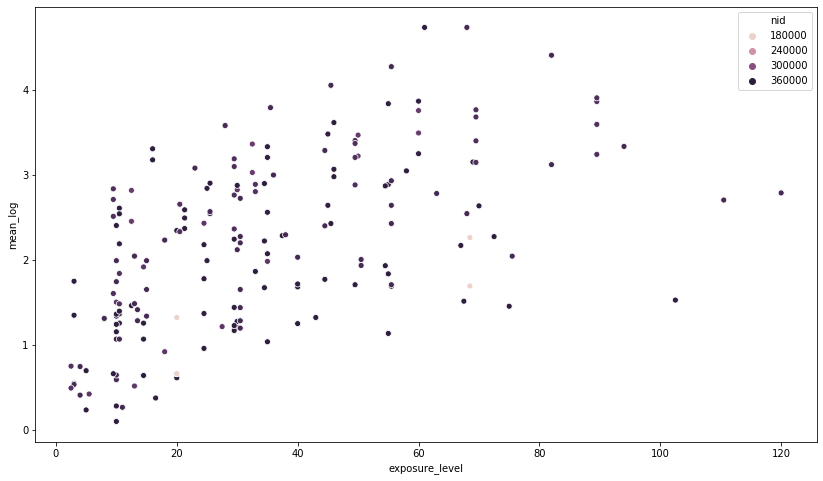

In [35]:
plt.figure(figsize=(14,8))
sns.scatterplot(x=data["exposure_level"], y=data["mean_log"], hue=data["nid"])

## Fitting a real data

In [36]:
X_smoking = data[["nid", "exposure_level", "se_log_tmp"]].to_numpy()
y_smoking = data["mean_log"].to_numpy()
smoking_features_labels = np.array([[
    0,   # the first column is group labels
    3,   # the second column is a random feature
    4,   # the third column is measurement errors
]])
X_smoking = np.concatenate([smoking_features_labels, X_smoking], axis=0) # add the first line (labels)

In [37]:
model_parameters = {
            "nnz_tbeta": 2,  
            "nnz_tgamma": 2, 
            "lb": 0,         # We expect no sparsity in our solution
            "lg": 0,         # Same
            "initializer": "EM",  # Initialize with EM one iteration of EM algorithm
            "logger_keys": ('converged', 'loss',),
            "tol": 1e-6,
            "n_iter": 1000,
            "tol_inner": 5e-4,
            "n_iter_inner": 20
        }

model = LinearLMESparseModel(**model_parameters)

In [38]:
model.fit(X_smoking, y_smoking, random_intercept=True)
y_smoking_pred = model.predict(X_smoking)
print("MSE: %.3f \nExplained variance: %.2f" % 
      (mean_squared_error(y_smoking, y_smoking_pred), explained_variance_score(y_smoking, y_smoking_pred)))

MSE: 2.022 
Explained variance: -0.94


In [39]:
X_smoking = X_smoking[1:, :]

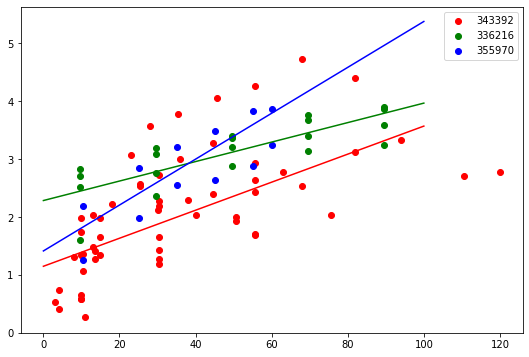

In [40]:
coefficients = model.coef_

plt.figure(figsize=(9, 6))
groups_to_plot = [343392, 336216, 355970]
colors = ['r', 'g', 'b']
for label, c in zip(groups_to_plot, colors):
    idx_of_this_label_in_train = np.where(coefficients["group_labels"] == label)[0]
    per_group_coefs = coefficients["per_group_coefficients"][idx_of_this_label_in_train][0]
    idxs = X_smoking[:, 0] == label
    plt.scatter(X_smoking[idxs][:, 1], y_smoking[idxs], c=c, label=label)
    plt.plot([0, 100], [per_group_coefs[0], per_group_coefs[0]+100*per_group_coefs[2]], c=c)
legend()

## Sparse spline regression on a real data

In [41]:
basis = dmatrix("bs(x, knots=(30, 60), degree=3)", {"x": data["exposure_level"].to_numpy()})

X_smoking = data[["nid", "se_log_tmp"]].to_numpy()
X_smoking = np.concatenate([X_smoking, basis[:, 1:]], axis=1)
y_smoking = data["mean_log"].to_numpy()
smoking_features_labels = np.array([[
    0,   # the first column is group labels
    4,   # the second column is measurement errors
    3,   # and we have 5 fixed+random features
    3, 
    3, 
    3, 
    3
]])
X_smoking = np.concatenate([smoking_features_labels, X_smoking], axis=0) # add the first line (labels)

In [42]:
model_parameters = {
            "nnz_tbeta": 3,       # We want to keep only three splines
            "nnz_tgamma": 3,      # They are allowed to have a random component
            "lb": 10,         
            "lg": 10,         
            "initializer": "EM",  # Initialize with EM one iteration of EM algorithm
            "logger_keys": ('converged', 'loss',),
            "tol": 1e-6,
            "n_iter": 1000,
            "tol_inner": 5e-4,
            "n_iter_inner": 20
        }

model = LinearLMESparseModel(**model_parameters)

In [43]:
model.fit(X_smoking, y_smoking, random_intercept=True)
y_smoking_pred = model.predict(X_smoking)
y_smoking_pred_sparse = model.predict(X_smoking, use_sparse_coefficients=True)
print("Dense coefficients:  MSE = %.3f; explained variance = %.2f" % 
      (mean_squared_error(y_smoking, y_smoking_pred), explained_variance_score(y_smoking, y_smoking_pred)))
print("Sparse coefficients: MSE = %.3f; explained variance = %.2f" % 
      (mean_squared_error(y_smoking, y_smoking_pred_sparse), explained_variance_score(y_smoking, y_smoking_pred_sparse)))

Dense coefficients:  MSE = 1.938; explained variance = -0.85
Sparse coefficients: MSE = 1.947; explained variance = -0.86


In [44]:
coefficients = model.coef_
print("Found beta:      %s"%coefficients["beta"])
print("Found tbeta:     %s"%coefficients["tbeta"])
print("Found gamma:     %s"%coefficients["gamma"])
print("Found tgamma:    %s"%coefficients["tgamma"])

Found beta:      [     0.929      0.388      1.487      2.183      0.615      0.421]
Found tbeta:     [     0.929      0.000      1.487      2.183      0.000      0.000]
Found gamma:     [     0.351      0.197      0.495      0.000      0.429      0.298]
Found tgamma:    [     0.351      0.000      0.495      0.000      0.000      0.000]


In [45]:
group_labels = X_smoking[1:, 0]    # Saving groups labels
X_smoking = np.concatenate([np.ones((199, 1)), X_smoking[1:, :]], axis=1) # adding inercept, dropping column labels

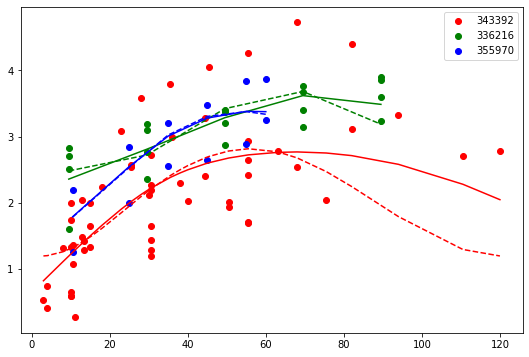

In [46]:
plt.figure(figsize=(9, 6))
groups_to_plot = [343392, 336216, 355970]
colors = ['r', 'g', 'b']
X_smoking_exposure = data["exposure_level"].to_numpy()
for label, c in zip(groups_to_plot, colors):
    idx_of_this_label_in_train = np.where(coefficients["group_labels"] == label)[0]
    per_group_coefs = coefficients["per_group_coefficients"][idx_of_this_label_in_train][0]
    sparse_per_group_coefs = coefficients["sparse_per_group_coefficients"][idx_of_this_label_in_train][0]
    #print(label, ":\n", per_group_coefs, '\n', sparse_per_group_coefs)
    idxs = group_labels == label
    plt.scatter(X_smoking_exposure[idxs], y_smoking[idxs], c=c, label=label)
    x_axis = X_smoking_exposure[idxs]
    spline = X_smoking[idxs].dot(per_group_coefs)
    sparse_spline = X_smoking[idxs].dot(sparse_per_group_coefs)
    tt = np.array(sorted(zip(x_axis, spline, sparse_spline), key=lambda x: x[0])).T
    plt.plot(tt[0], tt[1], c=c)
    plt.plot(tt[0], tt[2], '--', c=c)
plt.legend()

## Setting the formatter back to its original settings

In [47]:
np.set_printoptions(edgeitems=3,infstr='inf', linewidth=75, nanstr='nan', precision=8, suppress=False, threshold=1000, formatter=None)